# 1. Prepare

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import math
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, imread, imsave, figure
import pandas as pd
import numpy as np
import sys
import os
from skimage.color import rgb2gray
from skimage.transform import rescale, resize
import seaborn as sns

#Keras:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

#Custom Functions:
ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)

from imports.utils.log_progress import log_progress
from imports.utils.visualization import Visualize
from imports.models.data_generator import DataGenerator
from imports.utils.enums import DATA_BASE_PATH, SHAPE
from imports.models.u_net import get_unet
from imports.utils.utils import rle_encode, rle_decode

DATA_IMAGE_PATH = DATA_BASE_PATH + '/Images'
DATA_MASK_PATH = DATA_BASE_PATH + '/Masks'

SHAPE = (512,768)

Using TensorFlow backend.


In [3]:
import warnings
warnings.filterwarnings("ignore")

### Check if GPU available:

In [4]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

### Read Dataframes:

In [5]:
df = pd.read_pickle(DATA_BASE_PATH+"/df")
df.head(1)

,image_path,mask_path,mask_cirlce_path,name,dataset,mask_rle,mask_circle_rle,roots,splines
0,../data/00_all/images/,../data/00_all/masks/,../data/00_all/masks_autogen/,img_1000.png,None,773 253 1061 130 2308 255 2596 131 3845 254 41...,210163 81 214744 135 219334 171 223927 201 228...,"[[947.6608444830582, 198.98217169159952]]","[[[650.1494324934839, 103.97898089758343], [72..."


### Load Splited Data

In [6]:
train_df = pd.read_pickle(DATA_BASE_PATH+'/train_df')
val_df = pd.read_pickle(DATA_BASE_PATH+'/val_df')
test_df = pd.read_pickle(DATA_BASE_PATH+'/test_df')

print("Number of training Samples:", len(train_df))
print("Number of validation Samples:", len(val_df))
print("Number of test Samples:", len(test_df))

Number of training Samples: 354
Number of validation Samples: 102
Number of test Samples: 51


In [8]:
imgs = os.listdir(DATA_BASE_PATH+"/02_augmented/images")
files = {"image_path":DATA_BASE_PATH+"/02_augmented/images/",
             "mask_path":DATA_BASE_PATH+"/02_augmented/masks/",
             "mask_cirlce_path":DATA_BASE_PATH+"/02_augmented/masks_autogen/",
             "name":imgs}
aug_df = pd.DataFrame.from_dict(files)
aug_df.sample(3)
print(len(aug_df))

3540


In [9]:
train_df.sample(1)

,image_path,mask_path,mask_cirlce_path,name,dataset,mask_rle,mask_circle_rle,roots,splines
345,../data/00_all/images/,../data/00_all/masks/,../data/00_all/masks_autogen/,img_1363.png,None,2769 51 4304 53 5839 54 7374 55 8909 56 10445 ...,3517 135 8107 171 12700 201 17296 225 21892 24...,"[[792.1821470026063, 586.0468363636364], [1194...","[[[606.9680375325803, 994.4396387571921], [644..."


# 3 Training:

Weighted Loss Map Test:

In [10]:
# siehe notebook

### 3.1 Load UNet Model:

In [11]:
model = get_unet(input_shape=(*SHAPE,3),num_classes=2)

In [12]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 768, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 768, 8)  224         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 512, 768, 8)  32          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 512, 768, 8)  0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

### 3.2 Define Train- Generator:

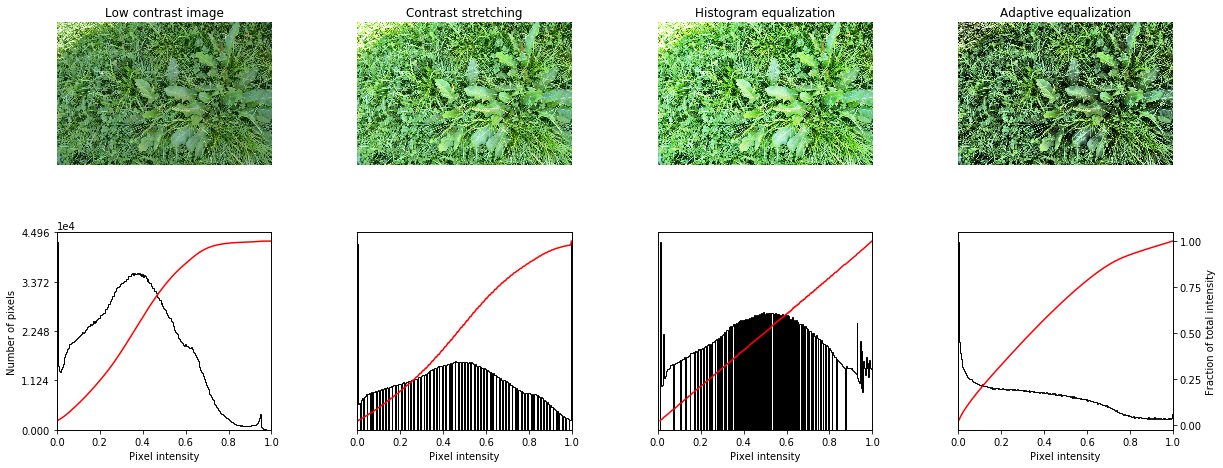

In [13]:
import matplotlib.pyplot as plt
import numpy as np

from skimage import data, img_as_float
from skimage import exposure


def plot_img_and_hist(img, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    img = img_as_float(img)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(img, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(img.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(img, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf


# Load an example image
img = imread(DATA_BASE_PATH + "/00_all/images/img_1001.png")

# Contrast stretching
p2 = np.percentile(img, 2)
p98 = np.percentile(img, 98)
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
img_adapteq = exposure.equalize_adapthist(img_adapteq, clip_limit=0.03)
img_adapteq = exposure.equalize_adapthist(img_adapteq, clip_limit=0.03)
img_adapteq = exposure.equalize_adapthist(img_adapteq, clip_limit=0.03)
img_adapteq = exposure.equalize_adapthist(img_adapteq, clip_limit=0.03)
img_adapteq = exposure.equalize_adapthist(img_adapteq, clip_limit=0.03)

# Display results
f, axes = plt.subplots(2, 4, figsize=(20, 8))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
plt.subplots_adjust(wspace=0.4)
plt.show()

In [ ]:
img = imread(DATA_BASE_PATH + "/02_augmented/images/aug_10000.png" )
img.max()

In [20]:
params = {'target_size': SHAPE,
          'batch_size': 4,
          'input_channels': 3,
          'shuffle': True}

# Generators
sample_gen = DataGenerator(df=val_df,hist_equal=True,augment_data=False,save_images=False,**params)
i_sample = iter(sample_gen)

Found 102 Files


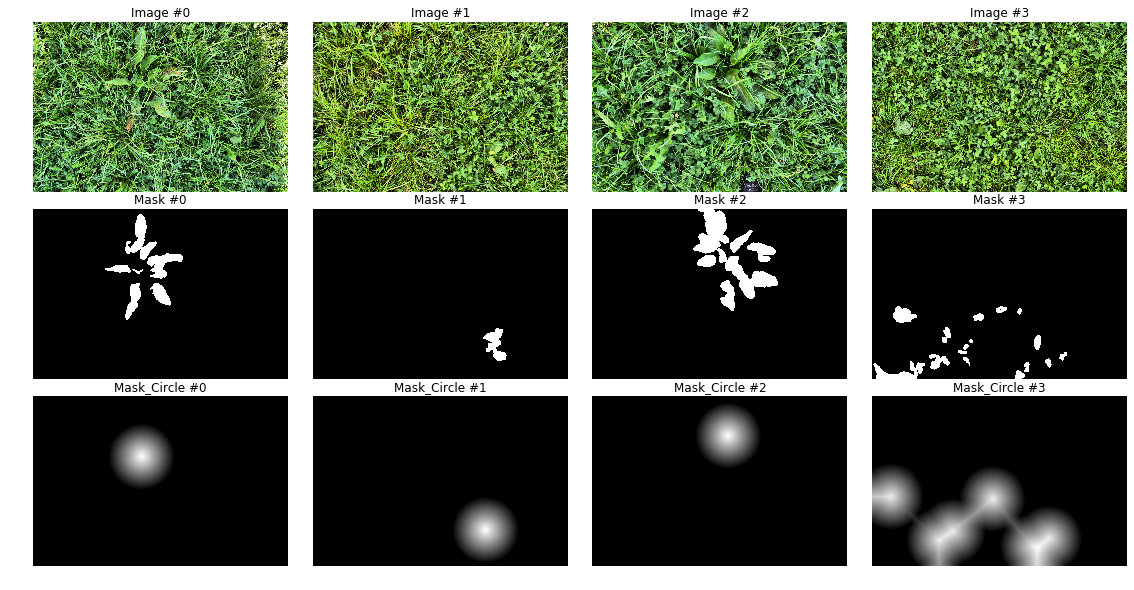

In [24]:
imgs,msks = next(i_sample)
plt.figure(figsize=(20,10))
x,y =4,1
for i in range(y):
    for j in range(x):
        plt.subplot(y*3,x,i*2*x+j+1)
        pos = i+j
        plt.imshow(imgs[pos,:,:,:].reshape(*SHAPE,3))
        plt.title('Image #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y*3,x,(i*2+1)*x+j+1)
        plt.imshow(msks[0][pos,:,:,:].reshape(SHAPE),cmap='gray')
        plt.title('Mask #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y*3,x,(i*2+2)*x+j+1)
        plt.imshow(msks[1][pos,:,:,:].reshape(SHAPE),cmap='gray')
        plt.title('Mask_Circle #{}'.format(pos))
        plt.axis('off')
        
plt.subplots_adjust(wspace=0.01, hspace=0.1)
plt.show()

### 3.3 Initialize Generators:

### 3.5 Train:

In [25]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard

BS = 6
import math
def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.2
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
    print("Learning Rate: " + str(lrate))
    return lrate

lrate = LearningRateScheduler(step_decay)


checkpoint = ModelCheckpoint('best_model.h5', 
                             monitor='val_dice_coeff', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max', 
                             save_weights_only = False)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coeff', 
                                   factor=0.1, 
                                   patience=6, 
                                   verbose=1, 
                                   mode='max', 
                                   epsilon=0.0001, 
                                   cooldown=6, 
                                   min_lr=0.0001)

early = EarlyStopping(monitor="val_dice_coeff", 
                      mode="max", 
                      patience=15,
                      restore_best_weights=True)

tensorboard = TensorBoard(log_dir='../docs/tensorboard', 
                            histogram_freq=0, 
                            batch_size=BS, 
                            write_graph=True, 
                            write_grads=False, 
                            write_images=False, 
                            embeddings_freq=0, 
                            embeddings_layer_names=None, 
                            embeddings_metadata=None, 
                            embeddings_data=None, 
                            update_freq='epoch')

callbacks_list = [early,lrate]

In [26]:
params = {'target_size': SHAPE,
          'batch_size': 6,
          'input_channels': 3,
          'shuffle': True}

# Generators
training_generator = DataGenerator(df=aug_df,augment_data=False,save_images=False,**params)
validation_generator = DataGenerator(df=val_df,hist_equal=True,**params)

Found 3540 Files
Found 102 Files


In [32]:
H = model.fit_generator(
    training_generator,
    steps_per_epoch=len(aug_df) // BS,
    validation_data=validation_generator,
    validation_steps=len(val_df) // BS,
    epochs=22,
    verbose=1,
    use_multiprocessing=True,
    workers=8,
    callbacks=callbacks_list)

Epoch 1/22
Learning Rate: 0.0001
590/590 [==============================] - 284s 481ms/step - loss: 0.5992 - map1_loss: 0.2289 - map2_loss: 0.1413 - map1_dice_coeff: 0.8224 - map2_iou: 0.9210 - val_loss: 0.7563 - val_map1_loss: 0.2945 - val_map2_loss: 0.1673 - val_map1_dice_coeff: 0.7833 - val_map2_iou: 0.9177
Epoch 2/22
Learning Rate: 0.0001
590/590 [==============================] - 281s 476ms/step - loss: 0.5626 - map1_loss: 0.2169 - map2_loss: 0.1288 - map1_dice_coeff: 0.8334 - map2_iou: 0.9342 - val_loss: 0.7291 - val_map1_loss: 0.2862 - val_map2_loss: 0.1567 - val_map1_dice_coeff: 0.7936 - val_map2_iou: 0.9285
Epoch 3/22
Learning Rate: 0.0001
590/590 [==============================] - 284s 482ms/step - loss: 0.5380 - map1_loss: 0.2083 - map2_loss: 0.1214 - map1_dice_coeff: 0.8407 - map2_iou: 0.9428 - val_loss: 0.7244 - val_map1_loss: 0.2848 - val_map2_loss: 0.1549 - val_map1_dice_coeff: 0.7913 - val_map2_iou: 0.9362

Epoch 4/22
Learning Rate: 0.0001
589/590 [=====================

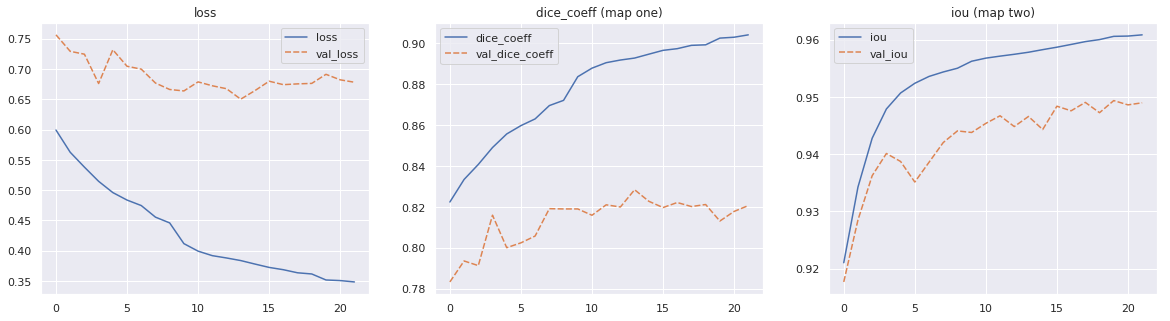

In [33]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
data = {#"epochs":np.linspace(0,len(H.history['dice_coeff']),len(H.history['dice_coeff'])),
        "loss":H.history['loss'],
        "val_loss":H.history['val_loss']}
loss_data = pd.DataFrame.from_dict(data)
sns.set(style="darkgrid")
ax = sns.lineplot(data=loss_data).set_title("loss")

plt.subplot(1,3,2)
data = {#"epochs":np.linspace(0,len(H.history['dice_coeff']),len(H.history['dice_coeff'])),
        "dice_coeff":H.history['map1_dice_coeff'],
        "val_dice_coeff":H.history['val_map1_dice_coeff']}
dice_data = pd.DataFrame.from_dict(data)
sns.set(style="darkgrid")
ax = sns.lineplot(data=dice_data).set_title("dice_coeff (map one)")

plt.subplot(1,3,3)
data = {#"epochs":np.linspace(0,len(H.history['dice_coeff']),len(H.history['dice_coeff'])),
        "iou":H.history['map2_iou'],
        "val_iou":H.history['val_map2_iou']}
iou_data = pd.DataFrame.from_dict(data)
sns.set(style="darkgrid")
ax = sns.lineplot(data=iou_data).set_title("iou (map two)")

In [34]:
model.save('unet_dice_0.8206_iou_0.9490.h5')

In [35]:
loss_data.to_pickle("loss_data_df_unet_dice_0.8206_iou_0.9490")
dice_data.to_pickle("dice_data_df_unet_dice_0.8206_iou_0.9490")
iou_data.to_pickle("iou_data_df_unet_dice_0.8206_iou_0.9490")

In [118]:
val_df.sample(1)

,image_path,mask_path,mask_cirlce_path,name,dataset,mask_rle,mask_circle_rle,roots,splines
13,../data/00_train_all/images/,../data/00_train_all/masks/,../data/00_train_all/masks_autogen/,img_1289.png,None,521988 5 523520 13 525055 15 526589 17 528124 ...,1588519 81 1593100 135 1597690 171 1602283 201...,"[[682.7104973066897, 592.434404602992], [1036....","[[[600.6163906168548, 545.6905132336019], [505..."


### 3.7 Visualize Error Mask

In [84]:
vis_params = {'data_set':'val',
              'model':model}

predictions = Visualize(**vis_params)

Aufsummiern aller falsch detektieren Masken (False Positive + False Negative):

In [12]:
def predict_all_error(df):
    error_sum = np.zeros(SHAPE)
    for i, row in df.iterrows():
        err = predictions.get_error_mask(index=row['Name'])
        error_sum += err
    return error_sum

In [13]:
summed_mask_error = predict_all_error(df.loc[df['Dataset'] == 'val'])

Visualisierung aller überlagerten False Positiv + False Negativ Masken:

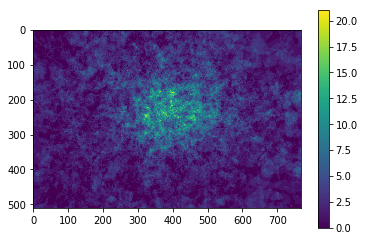

In [96]:
imshow(summed_mask_error)
plt.colorbar()

In [84]:
summed_mask_train = np.zeros(shape)
for i,row in df.iterrows():
    if row['Dataset'] == 'train':
        summed_mask_train += rle_decode(row['Mask'],(1024,1536))
summed_mask_train = resize(summed_mask_train,(512,768))

Vergleich der summierten Trainingsmasken (Bild rechts) mit den summierten Falschen vorhersagen (Bild mitte). Das Bild rechts zeigt die subtraktion der normalisierten Trainingsmasken mit den normalisierten False Positiv + False Negativ:

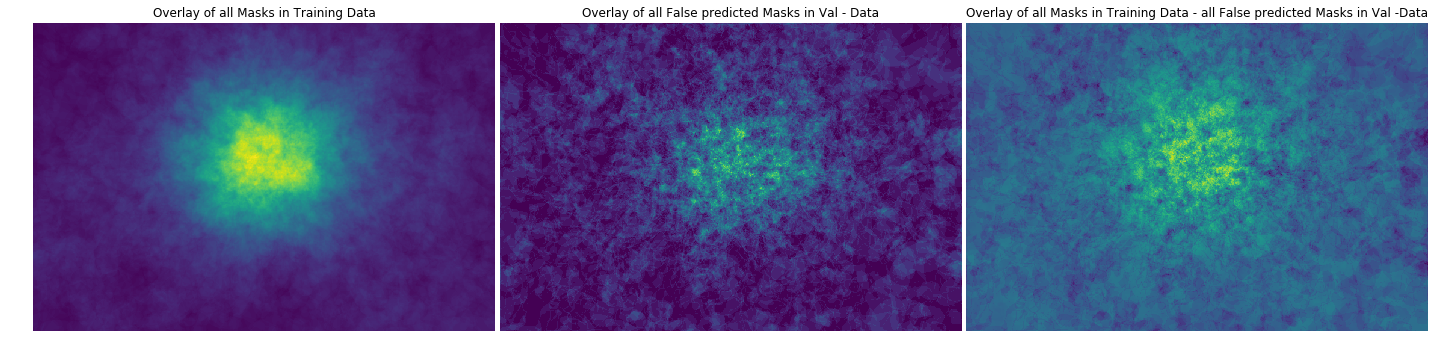

In [94]:
fig, axs = plt.subplots(ncols=3,nrows=1,figsize=(25,18))
axs[0].imshow(summed_mask_train)
axs[1].imshow(summed_mask_error)
#axs[1,0].imshow(summed_mask_train-summed_mask_error)
axs[2].imshow(summed_mask_train/summed_mask_train.max()-summed_mask_error/summed_mask_error.max())
axs[0].set_title('Overlay of all Masks in Training Data')
axs[0].axis('off')
axs[1].set_title('Overlay of all False predicted Masks in Val - Data')
axs[1].axis('off')
axs[2].set_title('Overlay of all Masks in Training Data - all False predicted Masks in Val -Data')
axs[2].axis('off')
plt.subplots_adjust(wspace=0.01, hspace=0)

Die meisten falsch vohergesagten Masken befinden sich zwar im Zentrum der Bilder (wie die meisten Masken in den Trainingsbildern), jedoch sind diese besser Verteilt als die Ground Truth Masken. (Die Farbskalierung der Bilder ist bei beiden gleich) 
Daraus schliesse ich, das sich die Anhäufung der GroundTruth- Masken in den Trainingsdaten im Zentrum, negativ auf die vorhersagen von Blacken im Randbereich asuwirkt. d.h. es werden im Randbereich der Bilder überdurchschnittlich viele Blacken falsch vorhergesagt.

<img src="../docs/notebook_images/False_negativ_positv.png">

float64


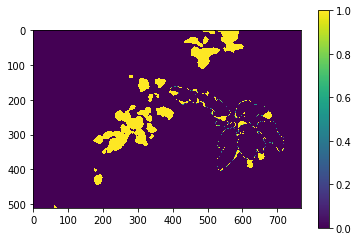

In [106]:
fe = predictions.get_full_error_mask(index='1357')
print(fe.dtype)
imshow(fe)
plt.colorbar()

float64


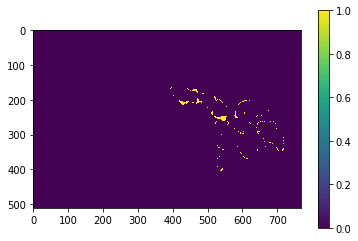

In [92]:
fp = predictions.get_false_positive_mask(index='1357')
print(fp.dtype)
imshow(fp)
plt.colorbar()

float64


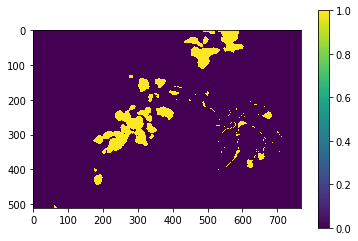

In [91]:
fn = predictions.get_false_negative_mask(index='1357')
print(fn.dtype)
imshow(fn)
plt.colorbar()

### Old: